In [1]:
PROMPT = r"I would like to answer the information to make an inference on a Bayesian Network. It is necessary to detect the variables of interest and the evidence presented in a question. The evidence is binary (yes, no). Only include evidence which is present on the question. The variables of interest should not be in the evidence. No explanation, no prediction of probability, only give short answer in this format, with a semicolon seperate them like this: variables_of_interest: []; evidence: {}"

In [2]:
import requests
import json
from IPython.display import display, Markdown, clear_output

def answer_this_prompt(prompt, stream=False, model="llama3:8b"):
    payload = {
        "prompt": prompt,
        "model": model,
        "temperature": 0,
        "max_new_tokens": 50 # only when stream = False work
    }
    headers = {
        'Content-Type': 'application/json'
    }
    endpoint = "http://localhost:11434/api/generate"
    payload_json = json.dumps(payload)

    # Send the POST request with streaming enabled
    with requests.post(endpoint, headers=headers, json=payload, stream=True) as response:
        if response.status_code == 200:
            try:
                # Process the response incrementally
                full_response = ""
                for line in response.iter_lines(decode_unicode=True):
                    if line.strip():  # Skip empty lines
                        response_json = json.loads(line)
                        chunk = response_json.get("response", "")
                        full_response += chunk
                        
                        # Render the response as Markdown
                        if stream:
                            clear_output(wait=True)
                            display(Markdown(full_response))
                        
                return full_response
            except json.JSONDecodeError as e:
                return "Failed to parse JSON: " + str(e)
        else:
            return "Failed to retrieve response: " + str(response.status_code)

# Example usage
# answer_this_prompt("What is the Big Bang theory?", stream=True)
# print("------------------------")

In [ ]:
from pgmpy.models import BayesianNetwork
from pgmpy.utils import get_example_model

asia = get_example_model('asia')
# print(asia.nodes())
print(asia.edges())
# print(asia.get_cpds())

def query_bn(bn, query_variables, evidence):
    """
    Perform exact inference on a Bayesian Network (BN) given the query variables and evidence.
    
    Args:
    - bn: A Bayesian Network object (pgmpy.models.BayesianNetwork).
    - query_variables: A list of strings specifying the query variables.
    - evidence: A dictionary where keys are strings of the evidence variables and values are the observed states.
    
    Returns:
    - A list of tuples where each tuple contains the state and probability of the query variable.
    """
    # Perform exact inference using Variable Elimination
    from pgmpy.inference import VariableElimination
    inference = VariableElimination(bn)
    result = inference.query(variables=query_variables, evidence=evidence)
    return result

# Example usage
query_variables = ['xray']
evidence = {'bronc': 'yes', 'either': 'yes', 'dysp': 'no', 'tub': 'no', 'asia': 'yes'}
result = query_bn(asia, query_variables, evidence)
string = str(result)
print(string)

[('asia', 'tub'), ('tub', 'either'), ('smoke', 'lung'), ('smoke', 'bronc'), ('lung', 'either'), ('bronc', 'dysp'), ('either', 'xray'), ('either', 'dysp')]
+-----------+-------------+
| xray      |   phi(xray) |
+===========+=============+
| xray(yes) |      0.9800 |
+-----------+-------------+
| xray(no)  |      0.0200 |
+-----------+-------------+


In [4]:
QUESTION = "What is the probability of a person having bronchits given they smoke?"
for i in range(1):
  answer_this_prompt('This is bayesian network:' + str(asia.edges()) + ' ' + PROMPT + ' Question: ' + QUESTION)
  print('---------------------------------------------')

ConnectionError: HTTPConnectionPool(host='localhost', port=11434): Max retries exceeded with url: /api/generate (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x339024830>: Failed to establish a new connection: [Errno 61] Connection refused'))

## Generate Questions

In [ ]:
question_list = []
QUESTION = "Give me a short human-like question to ask about this Bayesian network. Just question, no context. For example: What is the probability of a person having bronchitis given they smoke?"
for i in range(10):
  print(i + 1, end=' ')
  question = answer_this_prompt('This is bayesian network:' + str(asia.edges()) + '. Question: ' + QUESTION)
  question_list.append(question)
  # print(ques)
  # print('---------------------------------------------')

print()
print(question_list)

1 2 3 4 5 6 7 8 9 10 
['What is the likelihood that someone has pneumonia if we know they have both tuberculosis and lung disease?', "What is the likelihood that someone has a lung disease if an X-ray reveals that their lungs are abnormal and they don't have tuberculosis?", "What is the likelihood that someone has tuberculosis if they don't have any symptoms of lung disease but do have a lung X-ray indicating abnormalities?", 'What is the likelihood that someone has dyspnea if both their X-ray and CT scan come back normal?', 'What is the likelihood that someone has an X-ray result if we know they have tuberculosis?', "What's the chance that someone has pneumonia if they got an X-ray and also show symptoms of respiratory difficulty?", "What's the likelihood that someone has either tuberculosis or lung disease if their chest X-ray shows signs of respiratory distress?", "What is the likelihood that someone has lung disease if they don't have symptoms?", 'What is the likelihood that someon

In [ ]:
def parse_input(input_string):
    result = {"variables_of_interest": [], "evidence": {}}

    try:
        parts = input_string.split(';')
        for part in parts:
            key, value = part.split(':', 1)  
            key = key.strip()
            value = value.strip()
            
            if key == "variables_of_interest":
                result["variables_of_interest"] = [var.strip().strip("'") for var in value.strip('[]').split(',')]
            
            elif key == "evidence":
                value = value.strip('{}')
                items = value.split(',')
                for item in items:
                    var, val = item.split(':')
                    result["evidence"][var.strip().strip("'")] = val.strip().strip("'")

    except ValueError as e:
        return f"Error parsing input: {e}"
    
    return result

In [ ]:
from collections import Counter

def check_consistency(results):
    """
    Check the consistency of results by comparing each result to the majority result.
    
    Args:
        results (list): A list of parsed results (dictionaries).
    
    Returns:
        float: The percentage of consistent results.
        int: The number of inconsistent results.
        dict: The majority result.
    """
    if not results:
        print("No results to check.")
        return 0.0, 0, None

    # Find the majority result using Counter
    result_counts = Counter(map(str, results))  # Convert dictionaries to strings for counting
    majority_result_str, _ = result_counts.most_common(1)[0]
    majority_result = eval(majority_result_str)  # Convert the string back to a dictionary

    # Count inconsistencies
    inconsistent_count = sum(1 for result in results if result != majority_result)
    total_results = len(results)
    consistent_count = total_results - inconsistent_count
    consistency_percentage = (consistent_count / total_results) * 100

    return consistency_percentage, inconsistent_count, majority_result

#### Model: llama3:8b

In [ ]:
consistency_list = []

for i, question in enumerate(question_list):
      print('Question', i + 1, ':', question)
      rs = []
      for i in range(10):
            print(i+1, end=' ')
            response = answer_this_prompt('This is bayesian network:' + str(asia.edges()) + ' ' + PROMPT + ' Question: ' + question)

            result = parse_input(response)
            # print('llm result\n', result, end='\n\n')

            # string_result = str(query_bn(asia, result["variables_of_interest"], result["evidence"]))
            # # print('bn result\n', string_result, end='\n\n')

            # answer = answer_this_prompt('Based on this result: ' + string_result + '. Give a short answer this question: ' + QUESTION)
            # # print('\nllm answer based on bn result:\n', answer)
            print(result)
            rs.append(result)
            # print(answer)
      consistency_percentage, inconsistent_count, majority_result = check_consistency(rs)
      consistency_list.append(consistency_percentage)
      print(f"\nConsistency: {consistency_percentage:.2f}%")
      print(f"Inconsistent results: {inconsistent_count}")
      print(f"Majority result: {majority_result}")
      print('---------------------------------------------')
      print()

print(f'Average consistency: {sum(consistency_list) / len(consistency_list)}%')

Question 1 : What is the likelihood that someone has pneumonia if we know they have both tuberculosis and lung disease?
1 {'variables_of_interest': ['pneumonia'], 'evidence': {'tub': 'yes', 'lung': 'yes'}}
2 {'variables_of_interest': ['pneumonia'], 'evidence': {'tub': 'yes', 'lung': 'yes'}}
3 {'variables_of_interest': ['"pneumonia"'], 'evidence': {'"tub"': '"yes"', '"lung"': '"yes"'}}
4 {'variables_of_interest': ['pneumonia'], 'evidence': {'tub': 'yes', 'lung': 'yes'}}
5 {'variables_of_interest': ['pneumonia'], 'evidence': {'tub': 'yes', 'lung': 'yes'}}
6 {'variables_of_interest': ['"pneumonia"'], 'evidence': {'"tub"': '"yes"', '"lung"': '"yes"'}}
7 {'variables_of_interest': ['pneumonia'], 'evidence': {'asia': 'no', 'tub': 'yes', 'smoke': 'no', 'lung': 'yes'}}
8 {'variables_of_interest': ['pneumonia'], 'evidence': {'tub': 'yes', 'lung': 'yes'}}
9 {'variables_of_interest': ['pneumonia'], 'evidence': {'tub': 'yes', 'lung': 'yes'}}
10 {'variables_of_interest': ['pneumonia'], 'evidence': {

#### Model: phi4:latest

In [ ]:
# PROMPT = r"I would like to answer the information to make an inference on a Bayesian Network. It is necessary to detect the variables of interest and the evidence presented in a question. The evidence is binary (yes, no). Only include evidence which is present on the question. The variables of interest should not be in the evidence. No explanation, no prediction of probability, only give short answer in this format, with a semicolon seperate them like this: variables_of_interest: []; evidence: {}"

consistency_list = []

for i, question in enumerate(question_list):
      print('Question', i + 1, ':', question)
      rs = []
      for i in range(10):
            print(i+1, end=' ')
            response = answer_this_prompt('This is bayesian network:' + str(asia.edges()) + ' ' + PROMPT + ' Question: ' + question, model="phi4:latest")

            result = parse_input(response)
            # print('llm result\n', result, end='\n\n')

            # string_result = str(query_bn(asia, result["variables_of_interest"], result["evidence"]))
            # # print('bn result\n', string_result, end='\n\n')

            # answer = answer_this_prompt('Based on this result: ' + string_result + '. Give a short answer this question: ' + QUESTION)
            # # print('\nllm answer based on bn result:\n', answer)
            # print(result)
            rs.append(result)
            # print(answer)
      consistency_percentage, inconsistent_count, majority_result = check_consistency(rs)
      consistency_list.append(consistency_percentage)
      print(f"\nConsistency: {consistency_percentage:.2f}%")
      print(f"Inconsistent results: {inconsistent_count}")
      print(f"Majority result: {majority_result}")
      print('---------------------------------------------')
      print()

print(f'Average consistency: {sum(consistency_list) / len(consistency_list)}%')

Question 1 : What is the likelihood that someone has an X-ray if they have symptoms of dyspnea?
1 2 3 4 5 6 7 8 9 10 
Consistency: 70.00%
Inconsistent results: 3
Majority result: {'variables_of_interest': ['xray'], 'evidence': {'dysp': 'yes'}}
---------------------------------------------

Question 2 : What's the likelihood that someone has pneumonia if they had an x-ray and didn't have dyspnea?
1 2 3 4 5 6 7 8 9 10 
Consistency: 60.00%
Inconsistent results: 4
Majority result: {'variables_of_interest': ['asia'], 'evidence': {'xray': 'yes', 'dysp': 'no'}}
---------------------------------------------

Question 3 : What's the likelihood that someone has pneumonia if their chest X-ray shows signs of disease?
1 2 3 4 5 6 7 8 9 10 
Consistency: 30.00%
Inconsistent results: 7
Majority result: {'variables_of_interest': ['asia', 'tub'], 'evidence': {'xray': 'yes'}}
---------------------------------------------

Question 4 : What is the likelihood that a person with abnormal lung function also 

#### Small test

In [ ]:
QUESTION = "This person have bronchitis. Why this person having bronchitis?"
response = answer_this_prompt('This is bayesian network:' + str(asia.edges()) + ' ' + PROMPT + ' Question: ' + QUESTION, stream=True)
dict_response = parse_input(response)
print(dict_response, end='\n\n')

string_result = str(query_bn(asia, dict_response["variables_of_interest"], dict_response["evidence"]))
answer = answer_this_prompt('Based on this result: ' + string_result + '. Give a short answer this question: ' + QUESTION)
print(answer)

variables_of_interest: ['smoke', 'asia']; evidence: {'lung': 'no'}

{'variables_of_interest': ['smoke', 'asia'], 'evidence': {'lung': 'no'}}

Based on the result, it seems that there is a high probability of the person not having bronchitis (smoke=no and asia=no) since phi(smoke,asia)=0.5186, which is the highest value among all combinations. This suggests that the person's smoking habit and geographic location (Asia or not Asia) are not strongly associated with having bronchitis.


In [6]:
import numpy as np
from pgmpy.inference import VariableElimination
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD

health_bn = DiscreteBayesianNetwork([
    ('Smoking', 'LungCancer'),
    ('Genetics', 'LungCancer'),
    ('LungCancer', 'Cough'),
    ('LungCancer', 'Fatigue'),
    ('LungCancer', 'Xray'),
    ('Cold', 'Cough'),
    ('Cold', 'Fever'),
    ('Fever', 'Fatigue')
])

# Define the CPDs (Conditional Probability Distributions)
cpd_smoking = TabularCPD('Smoking', 2, [[0.8], [0.2]])  # 0: No, 1: Yes
cpd_genetics = TabularCPD('Genetics', 2, [[0.9], [0.1]])  # 0: No, 1: Yes
cpd_lung_cancer = TabularCPD('LungCancer', 2, 
                             [[0.99, 0.90, 0.85, 0.50],  # P(LungCancer=0 | Smoking, Genetics)
                              [0.01, 0.10, 0.15, 0.50]], # P(LungCancer=1 | Smoking, Genetics)
                             evidence=['Smoking', 'Genetics'], evidence_card=[2, 2])
cpd_cough = TabularCPD('Cough', 2, 
                       [[0.9, 0.3, 0.6, 0.1],  # P(Cough=0 | LungCancer, Cold)
                        [0.1, 0.7, 0.4, 0.9]], # P(Cough=1 | LungCancer, Cold)
                       evidence=['LungCancer', 'Cold'], evidence_card=[2, 2])
cpd_fatigue = TabularCPD('Fatigue', 2, 
                         [[0.8, 0.4, 0.6, 0.2],  # P(Fatigue=0 | LungCancer, Fever)
                          [0.2, 0.6, 0.4, 0.8]], # P(Fatigue=1 | LungCancer, Fever)
                         evidence=['LungCancer', 'Fever'], evidence_card=[2, 2])
cpd_xray = TabularCPD('Xray', 2, 
                      [[0.95, 0.2],  # P(Xray=0 | LungCancer)
                       [0.05, 0.8]], # P(Xray=1 | LungCancer)
                      evidence=['LungCancer'], evidence_card=[2])
cpd_cold = TabularCPD('Cold', 2, [[0.7], [0.3]])  # 0: No, 1: Yes
cpd_fever = TabularCPD('Fever', 2, 
                       [[0.8, 0.4],  # P(Fever=0 | Cold)
                        [0.2, 0.6]], # P(Fever=1 | Cold)
                       evidence=['Cold'], evidence_card=[2])

# Add CPDs to the Bayesian Network
health_bn.add_cpds(cpd_smoking, cpd_genetics, cpd_lung_cancer, cpd_cough, 
                   cpd_fatigue, cpd_xray, cpd_cold, cpd_fever)

print(query_bn(health_bn, ['LungCancer'], {'Smoking': 0, 'Genetics': 0, 'Cold': 0, 'Fever': 0, 'Cough': 0, 'Fatigue': 0, 'Xray': 0}))

+---------------+-------------------+
| LungCancer    |   phi(LungCancer) |
+===============+===================+
| LungCancer(0) |            0.9989 |
+---------------+-------------------+
| LungCancer(1) |            0.0011 |
+---------------+-------------------+


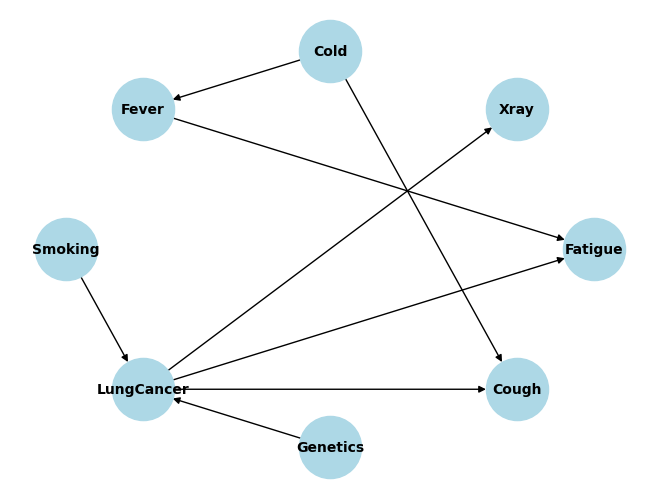

In [9]:
# draw bn
import networkx as nx
import matplotlib.pyplot as plt

pos = nx.shell_layout(health_bn)  # hoặc nx.spring_layout(), nx.circular_layout()
nx.draw(health_bn, pos=pos, with_labels=True,
        node_size=2000, node_color='lightblue',
        font_size=10, font_weight='bold')
plt.show()